# Interactive Learning Course
## HW #2, Multi-Armed Bandits

# Table of Contents

- [Packages](#0)
- [Part 2](#1)
    - [Reward class](#1-1)
    - [Environment](#1-2)
- [Part 3](#2)
    - [Agent Base](#2-1)
    - [Epsilon-Greedy Agent](#2-2)
    - [Gradient-Based Agent](#2-3)
    - [Upper Confidence Bound Agent](#2-4)
- [Part 4](#3)
    - [Student](#3-1)
    - [GovStaff](#3-2)
    - [SelfEmp](#3-3)
- [Part 5](#4)

<a name='0'></a>
## Packages

Run the following cell to load the packages you'll need.

In [157]:
import numpy as np
from abc import ABC, abstractmethod
import gym
import matplotlib.pyplot as plt
import math

TRIAL = 100
RUN = 20
REGRET = [5.1,20.75,105]

<a name='1'></a>
# Part 2

<a name='1-1'></a>
## Reward class

In [158]:
class Reward(ABC):
    def __init__(self, debts=[5.0, 20.0, 100.0]):
        super(Reward, self).__init__()
        self.debts = debts
        
    @abstractmethod
    def get_reward(self, action):
        pass

In [159]:
class Student(Reward):
    def __init__(self):
        super(Student, self).__init__()

    def get_reward(self, action):
        if action == 0:
            obs = np.random.choice([4, 5, 5.1], p=[0.2, 0.2, 0.6])
        elif action == 1:
            obs = np.random.choice([5, 10, 20, 20.75], p=[0.5, 0.3, 0.1, 0.1])
        else:
            obs = np.random.choice([10, 20, 50, 100, 105], p=[0.5, 0.3, 0.1, 0.05, 0.05])
        
        return obs, obs - self.debts[action]

In [160]:
class GovStaff(Reward):
    def __init__(self):
        super(GovStaff, self).__init__()

    def get_reward(self, action):
        if action == 0:
            obs = np.random.choice([4, 5, 5.1], p=[0.05, 0.3, 0.65])
        elif action == 1:
            obs = np.random.choice([5, 10, 20, 20.75], p=[0.1, 0.1, 0.3, 0.5])
        else:
            obs = np.random.choice([20, 50, 80, 100, 105], p=[0.1, 0.1, 0.2, 0.3, 0.3])
        
        return obs, obs - self.debts[action]

In [161]:
class SelfEmp(Reward):
    def __init__(self):
        super(SelfEmp, self).__init__()

    def get_reward(self, action):
        if action == 0:
            obs = np.random.choice([0, 2.5, 5.1], p=[0.8, 0.1, 0.1])
        elif action == 1:
            obs = np.random.choice([5, 10, 20, 20.75], p=[0.05, 0.05, 0.3, 0.6])
        else:
            obs = np.random.choice([20, 50, 80, 100, 105], p=[0.02, 0.03, 0.05, 0.2, 0.7])
        
        return obs, obs - self.debts[action]

<a name='1-2'></a>
## Environment

In [162]:
class Environment:
    def __init__(self, _id, reward):
        ## YOUR CODES ##
        self.id = _id
        self.reward = reward
        self.state_space = gym.spaces.Discrete(1)
        self.action_space = gym.spaces.Discrete(len(reward.debts))
    
    def calc_reward(self, action):
        ## YOUR CODES ##
        return self.reward.get_reward(action)

    def get_available_actions(self):
        ## YOUR CODES ##
        return self.action_space.n

<a name='2'></a>
# Part 3

<a name='2-1'></a>
## Agent Base

In [163]:
class Agent:
    def __init__(self, _id, env=None, alpha=0, beta=1, gamma=1):
        ## YOUR CODES ##
        self.id = _id
        self.env = env
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.all_rewards = []
        self.all_regrets = []

    @abstractmethod
    def choose_action(self):
        ## YOUR CODES ##
        pass
    
    def calculate_utility(self, reward):
        ## YOUR CODES ##
        return self.beta * np.power(reward, self.gamma) + self.alpha
#         if reward >= 0 :
#             return np.power(reward, self.alpha)
#         else:
#             return -1 * self.gamma * np.power((-reward), self.beta)
    
    def take_action(self, action):
        obs, r = self.env.calc_reward(action)
#         print(action, obs, r)
        u = self.calculate_utility(r)
        self.update_value(action, u)
        return r, action , u
    
    @abstractmethod
    def update_value(self, action, util):
        ## YOUR CODES ##
        pass

    def step(self, best_reward, trial):
        ## YOUR CODES ##
        for i in range(trial):
            action = self.choose_action()
            reward, action, utility = self.take_action(action)
            self.all_rewards.append(reward)
            self.all_regrets.append(REGRET[action] - reward)

    @abstractmethod
    def reset(self):
        ## YOUR CODES ##
        pass
    
    def get_rewards(self):
        ## YOUR CODES ##
        return self.all_rewards
    
    def get_regrets(self):
        ## YOUR CODES ##
        return self.all_regrets

<a name='2-2'></a>
## Epsilon-Greedy Agent

In [164]:
class EpsilonGreedyAgent(Agent):
    def __init__(self, _id, env, alpha=0, beta=1, gamma=1, epsilon=0.1, epsilon_decay=1):
        super(EpsilonGreedyAgent, self).__init__(_id, env, alpha, beta, gamma)
        ## YOUR CODES ##
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.available_actions = self.env.get_available_actions()
        self.Q = np.zeros((self.available_actions,1))     #action value fuction
        self.N = np.zeros((self.available_actions,1))     #number of doing an action 

    def choose_action(self):
        rand = np.random.rand()
        if rand < self.epsilon:
            action = np.random.choice(self.available_actions)
        else:
            action = np.argmax(self.Q)
        return action
    
    def update_value(self, action, util):
        ## YOUR CODES ##
        self.epsilon = self.epsilon * self.epsilon_decay
        self.N[action] += 1
        self.Q[action] += (util - self.Q[action])/self.N[action]

    def reset(self):
        ## YOUR CODES ##
        self.all_rewards = []
        self.all_regrets = []
        self.Q = np.zeros((self.available_actions,1))
        self.N = np.zeros((self.available_actions,1))

<a name='2-3'></a>
## Gradient-Based Agent

In [165]:
class GradientBasedAgent(Agent):
    def __init__(self, _id, env, alpha=0, beta=1, gamma=1, learning_rate = 0.0005,learning_rate_decay = 1):
        super(GradientBasedAgent, self).__init__(_id, env, alpha, beta, gamma)
        ## YOUR CODES ##
        self.learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.available_actions = self.env.get_available_actions()
        self.avg_rew = 0   
        self.N = 0      
        self.H = np.zeros((self.available_actions))
        self.P = (1/self.available_actions)*np.ones((self.available_actions))

    def choose_action(self):
        action = int(np.random.choice(list(range(self.available_actions)), size=1,p=self.P))
        return action
    
    def update_value(self, action, util):
        ## YOUR CODES ##
        self.learning_rate = self.learning_rate * self.learning_rate_decay
        self.N += 1
        self.avg_rew += (util - self.avg_rew)/self.N
        for i in range(len(self.H)):
            if i == action :
                self.H[i] += self.learning_rate*(util - self.avg_rew)*(1-self.P[i])
            else:
                self.H[i] -=  self.learning_rate*(util - self.avg_rew)*(self.P[i])
        for i in range(len(self.P)):
            self.P[i] = np.exp(self.H[i]) / np.sum(np.exp(self.H))

    def reset(self):
        ## YOUR CODES ##
        self.all_rewards = []
        self.all_regrets = []
        self.avg_rew = 0   
        self.N = 0      
        self.H = np.zeros((self.available_actions))
        self.P = (1/self.available_actions)*np.ones((self.available_actions))

<a name='2-4'></a>
## Upper Confidence Bound Agent

In [166]:
class UpperConfidenceBoundAgent(Agent):
    def __init__(self, _id, env, alpha=0, beta=1, gamma=1, exploration_degree = 4):
        super(UpperConfidenceBoundAgent, self).__init__(_id, env, alpha, beta, gamma)
        ## YOUR CODES ##
        self.exploration_degree = exploration_degree
        self.available_actions = self.env.get_available_actions()
        self.Q = np.zeros((self.available_actions,1))                 #action value fuction(expected reward) for each arm
        self.N = np.zeros((self.available_actions,1))                 #number of doing each arm
        self.trials = 0                                          #number of total trials 
        self.UCBs = 1000000000 * np.ones((self.available_actions,1))  #Upper confidence bound for each arm

    def choose_action(self):
        action = np.argmax(self.UCBs)
        return action
    
    def update_value(self, action, util):
        ## YOUR CODES ##
        self.trials += 1
        self.N[action] += 1
        self.Q[action] += (util - self.Q[action])/self.N[action] 
        self.UCBs[action] = self.Q[action] + self.exploration_degree * math.sqrt(np.log(self.trials)/self.N[action])

    def reset(self):
        ## YOUR CODES ##
        self.all_rewards = []
        self.all_regrets = []
        self.Q = np.zeros((self.available_actions,1))                 
        self.N = np.zeros((self.available_actions,1))                
        self.trials = 0                                         
        self.UCBs = 1000000000 * np.ones((self.available_actions,1))

<a name='3'></a>
# Part 4

In [170]:
def draw_ylabel_trial_plot(rewards, _ylabel, _title):   
    plt.figure(figsize=(8,6))
    plt.plot(range(1,TRIAL+1), rewards[0], label="Epsilon-Greedy")
    plt.plot(range(1,TRIAL+1), rewards[1], label="Gradient-Based")
    plt.plot(range(1,TRIAL+1), rewards[2], label="Upper Confidence Bound")
    plt.ylabel(_ylabel)
    plt.xlabel('Trials')
    plt.title(_title)
    plt.legend()
    plt.grid()
    plt.show()

In [173]:
def run(customer_type, customer_name, epsilon, learning_rate, exploration_degree):
    agent_1 = EpsilonGreedyAgent(0, env=Environment(0, customer_type), epsilon=epsilon)
    agent_2 = GradientBasedAgent(0, env=Environment(0, customer_type), learning_rate=learning_rate)
    agent_3 = UpperConfidenceBoundAgent(0, env=Environment(0, customer_type), exploration_degree=exploration_degree)

    mean_rewards = [np.zeros(TRIAL), np.zeros(TRIAL), np.zeros(TRIAL)]
    mean_regrets = [np.zeros(TRIAL), np.zeros(TRIAL), np.zeros(TRIAL)]

    for run in range(1, RUN+1):
        agent_1.step(0, TRIAL)
        rewards = agent_1.get_rewards()
        mean_rewards[0] = (mean_rewards[0] * (run-1) + rewards) /run
        regrets = agent_1.get_regrets()
        mean_regrets[0] = (mean_regrets[0] * (run-1) + regrets) /run
        agent_1.reset()

        agent_2.step(0, TRIAL)
        rewards = agent_2.get_rewards()
        mean_rewards[1] = (mean_rewards[1] * (run-1) + rewards) /run
        regrets = agent_2.get_regrets()
        mean_regrets[1] = (mean_regrets[1] * (run-1) + regrets) /run
        agent_2.reset()

        agent_3.step(0, TRIAL)
        rewards = agent_3.get_rewards()
        mean_rewards[2] = (mean_rewards[2] * (run-1) + rewards) /run
        regrets = agent_3.get_regrets()
        mean_regrets[2] = (mean_regrets[2] * (run-1) + regrets) /run
        agent_3.reset()

    draw_ylabel_trial_plot(mean_rewards, "Reward", customer_name)
    draw_ylabel_trial_plot(mean_regrets, "Regret", customer_name)

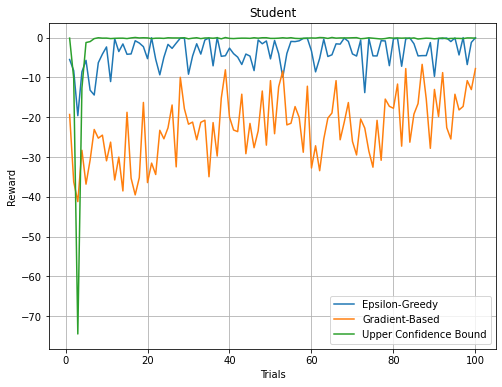

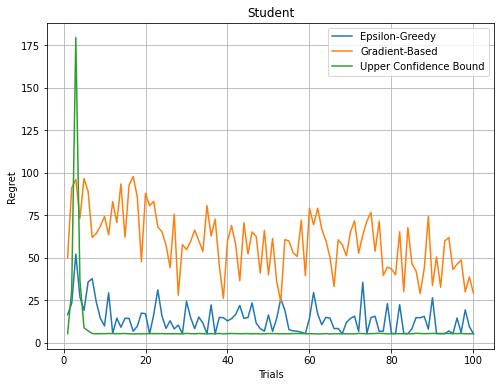

In [181]:
run(customer_type=Student(), customer_name="Student", epsilon=0.1, learning_rate=0.0005, exploration_degree=4)

<a name='3-1'></a>
## Student

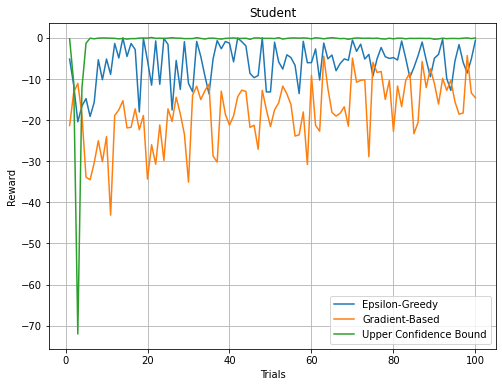

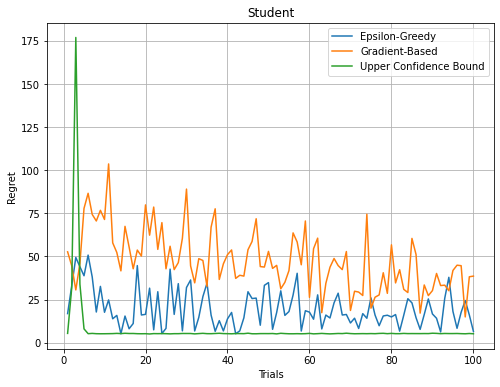

In [182]:
run(customer_type=Student(), customer_name="Student", epsilon=0.2, learning_rate=0.001, exploration_degree=2)

<a name='3-2'></a>
## GovStaff

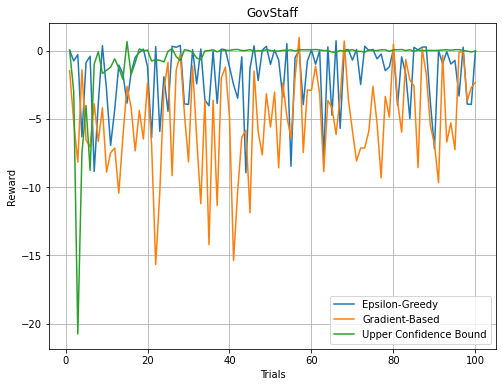

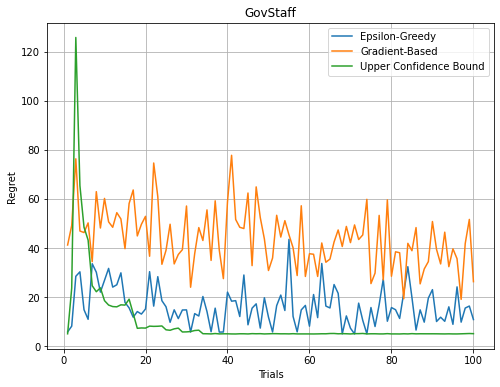

In [183]:
 run(customer_type=GovStaff(), customer_name="GovStaff", epsilon=0.2, learning_rate=0.001, exploration_degree=2)

<a name='3-3'></a>
## SelfEmp

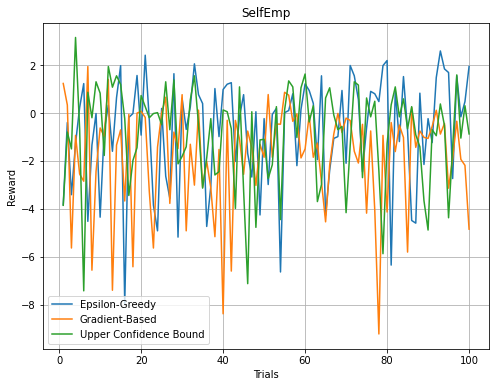

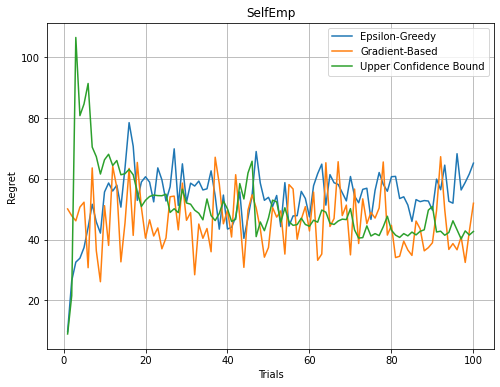

In [184]:
run(customer_type=SelfEmp(), customer_name="SelfEmp", epsilon=0.2, learning_rate=0.001, exploration_degree=2)

<a name='4'></a>
# Part 5